In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import pandas as pd
import scipy.stats as stats

In [2]:
import matplotlib
from matplotlib import rc
plt.rcParams.update({
    'font.family':'arial',
    'font.sans-serif':['Liberation Sans'],
    })
matplotlib.rcParams.update({'font.size':25})

In [3]:
#For Rat Dolo

ratErrCtM = np.array([[ 24.,  33.,   8.,   7.], [174.,  54.,   9.,  23.], [ 41.,  30., 112.,  21.]]) #error trial counts
ratTrCtM = np.array([[128., 554., 169., 109.], [639., 260.,  90., 144.], [ 79.,  56., 414.,  80.]]) #trial counts

## Fig. 4d

([<matplotlib.axis.YTick at 0x1a1c2283c8>,
 <a list of 4 Text yticklabel objects>)

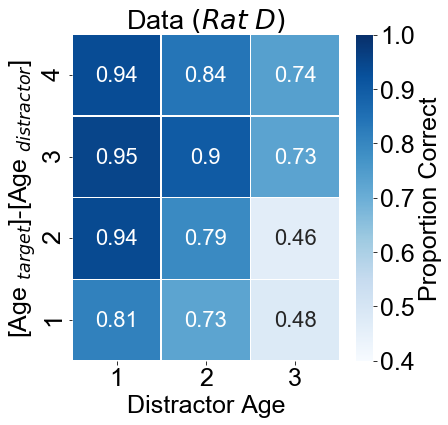

In [4]:
plt.figure(figsize=(6,6))
ratErrMT = ratErrCtM.transpose()/ratTrCtM.transpose()
ax = sns.heatmap(1.-ratErrMT, annot=True, linewidths = .5, 
                 cmap = 'Blues',annot_kws={"size": 22},vmin=0.4,vmax=1.,
                cbar_kws={'label': 'Proportion Correct'})
ax.invert_yaxis()
plt.ylabel('[Age $_{target}$]-[Age $_{distractor}$]', fontsize = 25) # need to set yticks
plt.xlabel('Distractor Age', fontsize = 25) # need to set xticks
plt.tick_params(labelsize=25)
plt.title('Data $(Rat$ $D)$', fontsize = 27)
plt.xticks([0.5,1.5,2.5], (1,2,3))
plt.yticks([0.5,1.5,2.5,3.5], (1,2,3,4))

In [5]:
def myefficerror(mynum,myden):
    #mynum = number of error trails
    #myden = total number of trails
    
    #we have myden total trials and a subset of them (mynum in total) are error trials.  We want to know the 
    #statistical uncertainy on the error rate, mynum / myden.  When mynum >> myden, sqrt(mynum) / myden is a
    #reasonable approximation since the Poisson uncertainty in myden is small compared to that of mynum, which 
    #is simply sqrt(mynum).  This is not quite correct because there is also a Poisson variation in the total
    #counts and mynum and myden are correlated.  So we want to compute the uncertainty on the ratio of two 
    #correlated Poisson random variables.

    #This function does that numerically.
    np.random.seed(seed=1)
    mybignumber = 100000
    nums = np.random.poisson(max(1,mynum),mybignumber)
    dens = np.random.poisson(myden-mynum,mybignumber) #the error and correct trails are independent
    dens+=nums
    myratios = nums/dens
    #be warned!  If mynum ~ myden, then this number may not be meaningful, because obviously,
    #the +1sigma of the error rate can't exceed 1!
    return np.nanstd(myratios)

([<matplotlib.axis.YTick at 0x1a1c3f9198>,
 <a list of 4 Text yticklabel objects>)

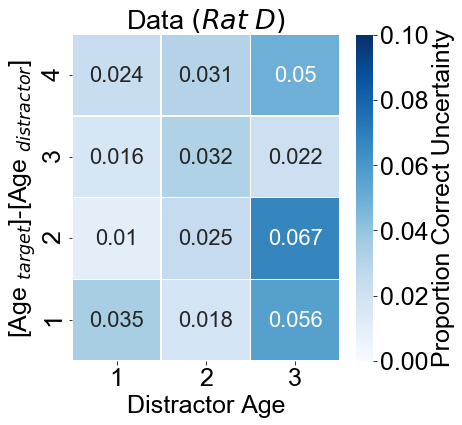

In [6]:
ratErrUncertM = np.zeros([3,4])
for i in range(3):
    for j in range(4):    
        ratErrUncertM[i,j] = myefficerror(ratErrCtM[i,j],ratTrCtM[i,j])
        pass
    pass
ratErrUncertMT = ratErrUncertM.transpose()

plt.figure(figsize=(6,6))
ax = sns.heatmap(ratErrUncertMT, annot=True, linewidths = .5, 
                 cmap = 'Blues',annot_kws={"size": 22},vmin=0.0,vmax=0.1,
                cbar_kws={'label': 'Proportion Correct Uncertainty'})
ax.invert_yaxis()
plt.ylabel('[Age $_{target}$]-[Age $_{distractor}$]', fontsize = 25) # need to set yticks
plt.xlabel('Distractor Age', fontsize = 25) # need to set xticks
plt.tick_params(labelsize=25)
plt.title('Data $(Rat$ $D)$', fontsize = 27)
plt.xticks([0.5,1.5,2.5], (1,2,3))
plt.yticks([0.5,1.5,2.5,3.5], (1,2,3,4))

In [7]:
#Let's define the fit function

ts = [1.,2.,3.] # 
Deltas = np.arange(1.,5,1.) 

def myerrorrateSim(a0,a1,a2,sigma0,t,delta,myn=100000):
    # polynomial model with lognormal distributions
    #print('t,delta',t,delta)
    #These are the mean and standard deviation of the log normal Y.
    mymean1 = a0*t
    mymean2 = a0*(t+delta) # t+delta, where delta and t both positive for lognormal
    mysigma1 = sigma0*(1.+a1*t+a2*t**2)
    mysigma2 = sigma0*(1.+a1*(t+delta)+a2*(t+delta)**2)

    #Let's compute the parameters of the log normal input Gaussian X, where Y = exp(X).
    sigma12 = np.log(mysigma1**2/mymean1**2+1.)
    mu1 = np.log(mymean1) - 0.5*sigma12
    sigma1 = np.sqrt(sigma12)
    
    sigma22 = np.log(mysigma2**2/mymean2**2+1.)
    mu2 = np.log(mymean2) - 0.5*sigma22
    sigma2 = np.sqrt(sigma22)

    sampArrayT = np.random.lognormal(mean = mu1, sigma = sigma1, size = myn) 
    sampArrayTD = np.random.lognormal(mean = mu2, sigma = sigma2, size = myn)

    draws = pd.DataFrame(data = {'sampsT':sampArrayT, 'sampsTD':sampArrayTD})
    draws['err'] = draws.sampsTD < draws.sampsT

    return sum(draws.err)/len(draws.err) # proportion of times that t is higher than t-delta dist.

def funSim(x,mymode="Fit",myn=100000):
    #mymode = "Fit" when fitting and "Eval" when just evaluating.
    
    #Let's just do MSE regression
    a0_guess = x[0]
    a1_guess = x[1] 
    a2_guess = x[2] 
    sigma_guess = x[3] 
    errorrates_guess = np.zeros((4,len(ts))) # always 3 distractor ages. maxcueyr set above, depends on our truncation
    errorrates_guess.fill(np.nan)
    for i in np.arange(len(ts)): #loop over target and distractor
        for j in np.arange(len(Deltas)): 
            errorrate_guess = myerrorrateSim(a0_guess,a1_guess,a2_guess,sigma_guess,ts[i],Deltas[j],myn)
            errorrates_guess[int(j),int(i)] = errorrate_guess
        pass
    pass       

    # MSE
    myoutput = np.nansum((myerrorrates - errorrates_guess)**2/myerrorrates_uncert**2)
    
    print("   ",a0_guess,a1_guess,a2_guess,sigma_guess,myoutput) #,myoutput_check)
    
    #print(x,myoutput)
    if (mymode=="Fit"):
        return myoutput
    elif (mymode=="Eval"):
        return errorrates_guess
    else:
        print("Sorry, that is not an option!")

In [8]:
x0 = np.array([1.19672951, 0.31732443, 0.37186628, 0.37458122]) # initialize 
myerrorrates = ratErrMT
myerrorrates_uncert = ratErrUncertMT
res = minimize(funSim, x0, method="Nelder-Mead",options={'maxiter':40})

ratLognormParams = res.x
ratLognormFitErrs = funSim(res.x,mymode="Eval")

    1.19672951 0.31732443 0.37186628 0.37458122 27.017742414656563
    1.2565659855 0.31732443 0.37186628 0.37458122 29.339176217749483
    1.19672951 0.3331906515 0.37186628 0.37458122 26.59444486912318
    1.19672951 0.31732443 0.390459594 0.37458122 26.623086020060256
    1.19672951 0.31732443 0.37186628 0.393310281 27.85190845217403
    1.1368930345 0.32525754075 0.3811629369999999 0.38394575049999996 33.88297857319117
    1.22664774775 0.3193077076875 0.37419044425 0.37692235262499996 27.107964057894463
    1.2116886288749997 0.32624917959375 0.38232501912499994 0.3570227253125 28.234406109017886
    1.2004692897187499 0.3195556173984375 0.37448096478125 0.384238392078125 26.82477733232832
    1.1686811621093747 0.3243898567617188 0.3801461151406251 0.3770686734140626 28.249813046330136
    1.2121561013398436 0.3205782449560547 0.3756793619726563 0.3769589328222656 26.93148237047872
    1.2063126955292969 0.3280000419272462 0.3843768203769532 0.3805986624501953 26.85961528159654
 

## Fig 4d
N.B. this may slightly differ from the one in the paper due to stochasticity in the fit.

([<matplotlib.axis.YTick at 0x1a1c925f60>,
 <a list of 4 Text yticklabel objects>)

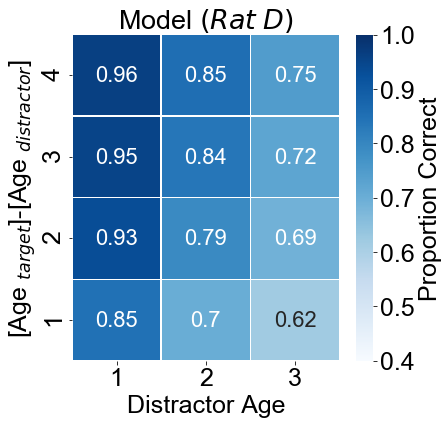

In [9]:
plt.figure(figsize=(6,6))
ratErrMT = ratErrCtM.transpose()/ratTrCtM.transpose()
ax = sns.heatmap(1.-ratLognormFitErrs, annot=True, linewidths = .5, 
                 cmap = 'Blues',annot_kws={"size": 22},vmin=0.4,vmax=1.,
                cbar_kws={'label': 'Proportion Correct'})
ax.invert_yaxis()
plt.ylabel('[Age $_{target}$]-[Age $_{distractor}$]', fontsize = 25) # need to set yticks
plt.xlabel('Distractor Age', fontsize = 25) # need to set xticks
plt.tick_params(labelsize=25)
plt.title('Model $(Rat$ $D)$', fontsize = 27)
plt.xticks([0.5,1.5,2.5], (1,2,3))
plt.yticks([0.5,1.5,2.5,3.5], (1,2,3,4))

## Fig. 4a and b

(0, 1)

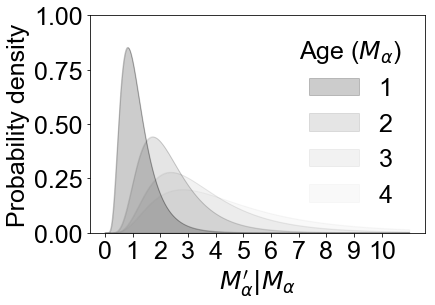

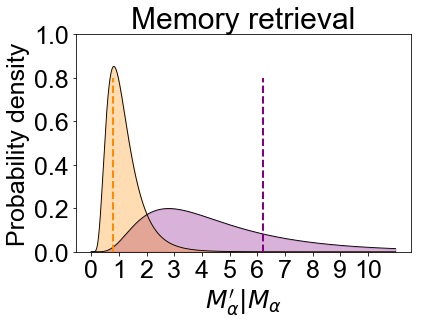

In [10]:
# make plots 

ratParams = ratLognormParams
alphas = {1:0.2, 2:0.1, 3: 0.05, 4: 0.025}
x = np.linspace(0,11,num=1000)

for t in [1,2,3,4]:
    
    sigma0 = ratParams[3]
    a0 = ratParams[0]
    a1 = ratParams[1]
    a2 = ratParams[2]
    mymean1 = a0*t
    mysigma1 = sigma0*(1.+a1*t+a2*t**2)

    #Let's compute the parameters of the log normal input Gaussian X, where Y = exp(X).
    sigma12 = np.log(mysigma1**2/mymean1**2+1.)
    mu1 = np.log(mymean1) - 0.5*sigma12
    sigma1 = np.sqrt(sigma12)

    plt.plot(x,stats.lognorm.pdf(x,s=sigma1,scale=np.exp(mu1)), linestyle = '-', color = 'k', alpha = alphas[t], linewidth = 0.9)
    plt.fill_between(x,0,stats.lognorm.pdf(x,s=sigma1,scale=np.exp(mu1)), color = 'k', alpha = alphas[t],label=str(t))
    plt.axhline(y=0, color = 'black', linewidth = 1)
    pass

plt.xticks(np.arange(11))
plt.xlabel(r"$M_\alpha'|M_\alpha$")
plt.ylabel('Probability density')
plt.legend(frameon=False,title=r"Age ($M_\alpha$)")
plt.ylim([0,1])

plt.figure()

for t in [4]:
    
    sigma0 = ratParams[3]
    a0 = ratParams[0]
    a1 = ratParams[1]
    a2 = ratParams[2]
    mymean1 = a0*t
    mysigma1 = sigma0*(1.+a1*t+a2*t**2)

    #Let's compute the parameters of the log normal input Gaussian X, where Y = exp(X).
    sigma12 = np.log(mysigma1**2/mymean1**2+1.)
    mu1 = np.log(mymean1) - 0.5*sigma12
    sigma1 = np.sqrt(sigma12)

    plt.plot(x,stats.lognorm.pdf(x,s=sigma1,scale=np.exp(mu1)), linestyle = '-', color = 'k', linewidth = 0.9)
    plt.axhline(y=0, color = 'black', linewidth = 1)
    pdf = stats.lognorm.pdf(x,s=sigma1,scale=np.exp(mu1))
    plt.fill_between(x,0,pdf, alpha = 0.3, color = 'purple')
    pass

for t in [1]:

    sigma0 = ratParams[3]
    a0 = ratParams[0]
    a1 = ratParams[1]
    a2 = ratParams[2]
    mymean1 = a0*t
    mysigma1 = sigma0*(1.+a1*t+a2*t**2)

    #Let's compute the parameters of the log normal input Gaussian X, where Y = exp(X).
    sigma12 = np.log(mysigma1**2/mymean1**2+1.)
    mu1 = np.log(mymean1) - 0.5*sigma12
    sigma1 = np.sqrt(sigma12)
    plt.plot(x,stats.lognorm.pdf(x,s=sigma1,scale=np.exp(mu1)), color = 'k', linewidth = 0.9)
    pdf = stats.lognorm.pdf(x,s=sigma1,scale=np.exp(mu1))
    plt.fill_between(x,0,pdf, alpha = 0.3, color = 'darkorange')

plt.axvline(0.8, ymax = 0.8, color = 'darkorange', lw = 2,ls = '--',alpha=1.,label="Recalled time, distractor")
plt.axvline(6.2, ymax = 0.8, color = 'purple', lw = 2,ls = '--',alpha=1.,label="Recalled time, target")
plt.ylim([0,1.3])
      
plt.yticks([0,0.2,0.4,0.6,0.8,1.0])    
plt.xticks(np.arange(11))
plt.title("Memory retrieval")
plt.xlabel(r"$M_\alpha'|M_\alpha$")
plt.ylabel('Probability density')
plt.ylim([0,1])

In [11]:
# define a function to compare draws from two distributions and gets confidence
# this takes the parameters of the lognormal fit 

def myconfSim(a0,a1,a2,sigma0,t,delta,nTrials):
    # polynomial model with lognormal distributions

    #These are the mean and standard deviation of the log normal Y.
    mymean1 = a0*t
    mymean2 = a0*(t+delta)
    mysigma1 = sigma0*(1.+a1*t+a2*t**2)
    mysigma2 = sigma0*(1.+a1*(t+delta)+a2*(t+delta)**2)

    #Let's compute the parameters of the log normal input Gaussian X, where Y = exp(X).
    sigma12 = np.log(mysigma1**2/mymean1**2+1.)
    mu1 = np.log(mymean1) - 0.5*sigma12
    sigma1 = np.sqrt(sigma12)
    
    sigma22 = np.log(mysigma2**2/mymean2**2+1.)
    mu2 = np.log(mymean2) - 0.5*sigma22
    sigma2 = np.sqrt(sigma22)
    
    # plot the two distributions
    plt.figure()
    x = np.linspace(0,10,100)
    plt.plot(x,stats.lognorm.pdf(x,s=sigma1,scale=np.exp(mu1)))
    plt.plot(x,stats.lognorm.pdf(x,s=sigma2,scale=np.exp(mu2)))
    plt.xlabel("Trial")
    plt.ylabel("Memory Density")
    
    sampArrayT = np.random.lognormal(mean = mu1, sigma = sigma1, size = nTrials) 
    sampArrayTD = np.random.lognormal(mean = mu2, sigma = sigma2, size = nTrials)

    confModel = pd.DataFrame(data = {'sampsT':sampArrayT, 'sampsTD':sampArrayTD})
    
    confModel['err'] = confModel.sampsTD<confModel.sampsT
    confModel['confDistance'] = abs(confModel.sampsTD - confModel.sampsT)
    
    return confModel

,memDiscrimLevel,dAges,tDiffs,fitErr,trCount,sampsT,sampsTD,sampsErr,sampsConfD
0,1_1,1,1,0.15204,128.0,"[1.1102053581615072, 2.4991505162776484, 0.702...","[1.4394520618118796, 2.9271070728180355, 4.548...","[False, False, False, False, False, True, Fals...","[0.32924670365037234, 0.4279565565403871, 3.84..."
1,1_2,1,2,0.06631,554.0,"[0.9075364799657701, 1.5738605899292617, 1.084...","[2.463377622826775, 2.4609497309431623, 1.3462...","[False, False, False, False, False, False, Fal...","[1.5558411428610048, 0.8870891410139006, 0.261..."
2,1_3,1,3,0.04508,169.0,"[2.1899267424299844, 0.6225296925104818, 0.995...","[2.982497940963224, 4.377718838988759, 6.28616...","[False, False, False, False, False, False, Fal...","[0.7925711985332398, 3.755189146478277, 5.2907..."
3,1_4,1,4,0.03657,109.0,"[2.9024867459378982, 4.170349198949771, 1.1283...","[1.894358750843399, 6.729299448865053, 2.71218...","[True, False, False, False, False, False, Fals...","[1.0081279950944992, 2.5589502499152816, 1.583..."
4,2_1,2,1,0.29738,639.0,"[3.279900188472959, 2.5539509445108814, 1.5343...","[4.470079521202987, 1.9687398118392014, 4.3880...","[False, True, False, False, True, True, False,...","[1.1901793327300276, 0.58521113267168, 2.85370..."


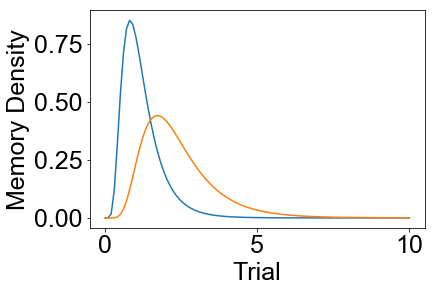

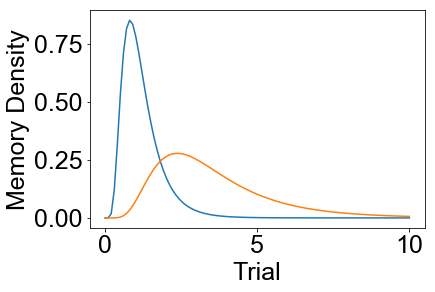

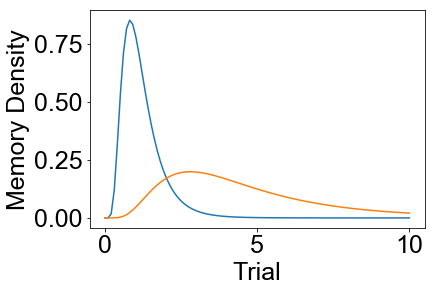

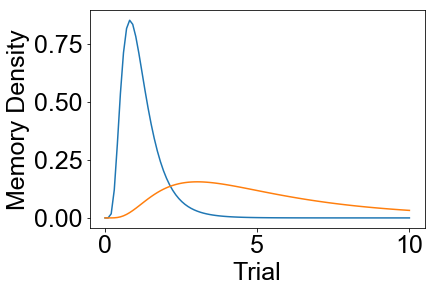

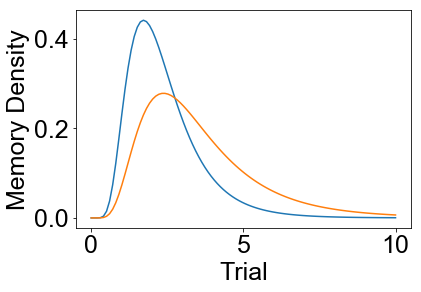

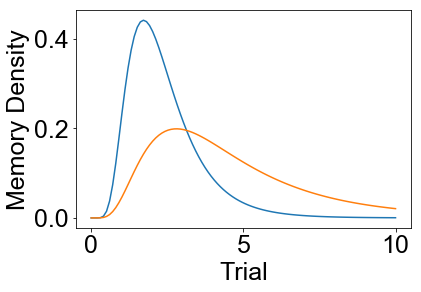

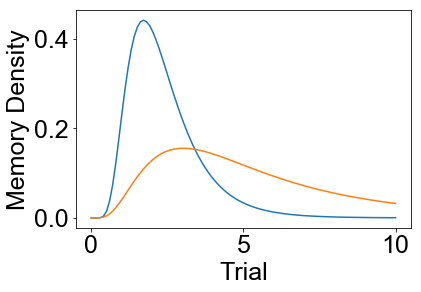

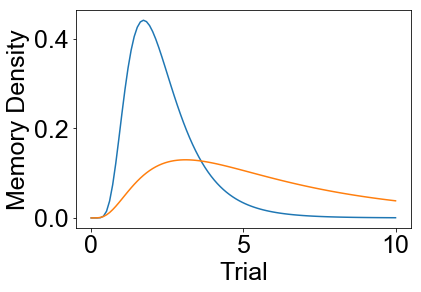

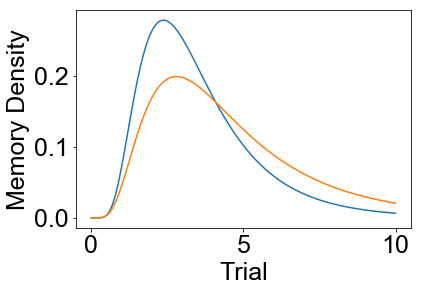

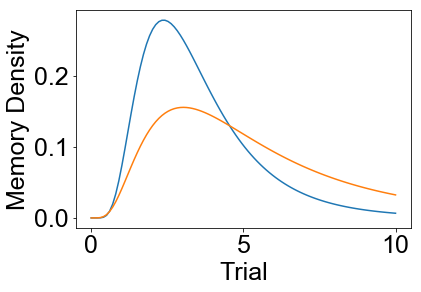

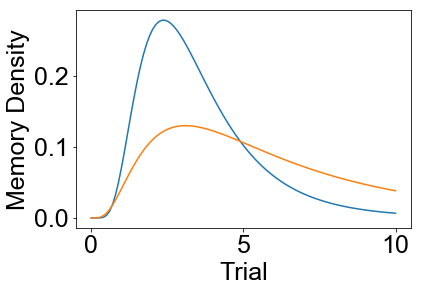

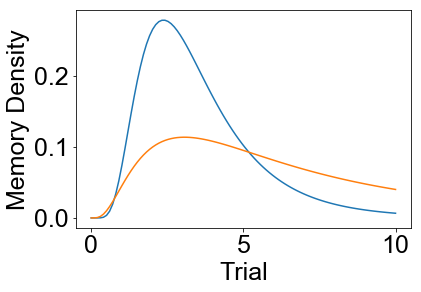

In [12]:
# create dataframe per rat with simulation inputs and outputs both
# this takes the parameters of the lognormal fit

nTrialsMin = 100000

mytrialcounts = ratTrCtM.transpose()
fit_errorrates = ratLognormFitErrs

# get factor to scale sampling for each memory discrim level
nTrialScale = mytrialcounts/sum(sum(mytrialcounts))
nTrialScale = nTrialScale/min(np.array(nTrialScale).flatten())

# read in model parameters
sigma0 = ratParams[3]
a0 = ratParams[0]
a1 = ratParams[1]
a2 = ratParams[2]

memLevels = []
fitErr = [] # this just stores the error rates read off the fit error matrix 
trCount = [] # stores n trials read off the fit error matrix
dAges = []
tDiffs = []
sampsT = []
sampsTD = []
sampsErr = []
sampsConfD = []
sampsConfDall = np.array([])
sampsErrall = np.array([])

for i in range(len(ts)):
    for j in range(len(Deltas)): 
        d_age = int(ts[i])
        t_diff = int(Deltas[j])
        memLevels += [str(d_age)+'_'+str(t_diff)]
        dAges += [d_age]
        tDiffs += [t_diff]
        fitErr += [fit_errorrates[j,i]]
        trCount += [mytrialcounts[j,i]]

        # how many trials to simulate for each confidence level? 
        nTrials = int(nTrialScale[j,i])*nTrialsMin

        #def myconfSim(a0,a1,a2,sigma0,t,delta,nTrials):
        # now simulate confidence based on the number of trials
        simConfs = myconfSim(a0,a1,a2,sigma0,float(d_age),float(t_diff),nTrials) # returns a dataframe with these col names - 

        #simConfs = myconfSim(a0,a1,a2,sigma0,float(d_age),float(t_diff),nTrials) # returns a dataframe with these col names - 
        sampsT += [list(simConfs.sampsT)]
        sampsTD += [list(simConfs.sampsTD)]
        sampsErr += [list(simConfs.err)]
        sampsConfD += [list(simConfs.confDistance)]     

        # separately save out all the confidence values in a list
        sampsConfDall = np.append(sampsConfDall,np.array(simConfs.confDistance))
        sampsErrall = np.append(sampsErrall,np.array(simConfs.err))

    pass
pass

modelDF = pd.DataFrame({'memDiscrimLevel': memLevels, 'dAges':dAges,'tDiffs':tDiffs, 'fitErr': fitErr, 'trCount':trCount})

modelDF['sampsT'] = sampsT
modelDF['sampsTD'] = sampsTD
modelDF['sampsErr'] = sampsErr
modelDF['sampsConfD'] = sampsConfD

modelDF.head()

## Fig. 4c

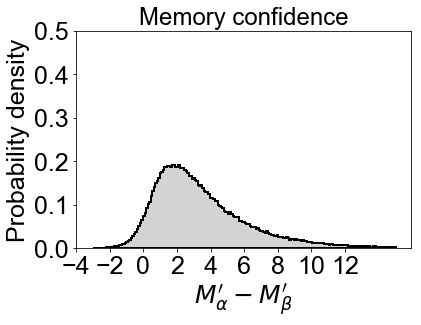

In [13]:
corrMeans = []
errMeans = []

# multiple difference distributions on same plot, fixed distractor age 1
plt.figure()
for i in [3]:
    DFslice = modelDF[(modelDF.tDiffs == i) & (modelDF.dAges ==1)] # distractor age 1, target ages 2,3,4
    corrPos = np.array(DFslice.iloc[0].sampsTD) - np.array(DFslice.iloc[0].sampsT) 
    corrMean = np.average(corrPos[corrPos > 0])
    errMean = np.average(corrPos[corrPos < 0])
    corrMeans += [corrMean]
    errMeans += [errMean]

    plt.hist(corrPos, bins = np.linspace(-3,15,num = 200), fill = True, histtype = 'stepfilled', 
             edgecolor = "black", lw = 2, density = True, color="lightgray")
    
plt.title('Memory confidence', fontsize = 24)
plt.xlabel(r"$M_\alpha'-M_\beta'$")
plt.ylabel('Probability density')
plt.ylim([0,0.5])
_=plt.yticks([0.,0.1,0.2,0.3,0.4,0.5])    
_=plt.xticks([-4,-2,0,2,4,6,8,10,12])